In [1]:
%pip install torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import render
import rooms.dataset
import evaluate
import torch
#import sounddevice as sd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import metrics

In [2]:
torch.set_default_dtype(torch.float32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device  = "cpu"

In [3]:
D_0 = rooms.dataset.dataLoader("classroomBase")
#D

In [4]:
D_1 = rooms.dataset.dataLoader("classroomAddedPanel")

## Original audio

In [6]:
'''
sample_rate = 48000

sd.play(D_0.music_dls[0][0], sample_rate)

sd.wait()
'''


'\nsample_rate = 48000\n\nsd.play(D_0.music_dls[0][0], sample_rate)\n\nsd.wait()\n'

## Base

In [5]:
print("Source position: ", D_0.speaker_xyz)
print("Listener position: ", D_0.xyzs[0])

Source position:  [3.5838 5.723  1.2294]
Listener position:  [2.4241125 0.581025  0.32     ]


In [4]:
L_0 = render.get_listener(source_xyz=D_0.speaker_xyz, listener_xyz = D_0.xyzs[0], surfaces=D_0.all_surfaces, 
                                                speed_of_sound=D_0.speed_of_sound,
                                                parallel_surface_pairs=D_0.parallel_surface_pairs,
                                                max_order=D_0.max_order, max_axial_order=D_0.max_axial_order )

Considered Paths:	59049
Total Considered Paths, after Axial:	59079
Valid Paths:	850


In [5]:
import torch
print(torch.version.cuda)  # Mostra la versione di CUDA compatibile
print(torch.cuda.is_available())  # Controlla se CUDA è disponibile


12.1
True


In [6]:
R_0 = render.Renderer(n_surfaces=len(D_0.all_surfaces))

n_freq_samples 1025
self.freq_grid tensor([0.0000e+00, 2.3438e+01, 4.6875e+01,  ..., 2.3953e+04, 2.3977e+04,
        2.4000e+04])
self.surfaces_freq_indices tensor([  1,   3,   5,  11,  21,  43,  85, 171, 341, 683], dtype=torch.int32)


In [7]:
# Utilizza più GPU se disponibili
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    R_0 = nn.DataParallel(R_0).module

In [8]:
pt_file = torch.load('./models/classroomBase/weights.pt', map_location=device)
R_0.energy_vector = nn.Parameter(pt_file['model_state_dict']['energy_vector'])
R_0.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R_0.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R_0.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R_0.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R_0.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

/tmp/ipykernel_9189/776745237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_file = torch.load('./models/classroomBase/weights.pt', map_location=device)


In [9]:
RIR_0 = R_0.render_RIR(L_0)

paths_without_transmissions tensor([ True,  True, False,  True, False,  True,  True,  True, False,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True, False,
         True, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False, False, False, False, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True, False, 

In [10]:
RIR_0

tensor([-4.2512e-10,  3.6879e-06,  5.5119e-06,  ...,  6.9838e-06,
         6.3781e-06,  6.7109e-06], device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
torch.cuda.empty_cache()

In [ ]:
RIR_with_learned_bp = R_0.render_early_with_learned_beampatterns(L_0)
RIR_with_learned_bp

In [10]:
len(RIR_with_learned_bp[4])

1025

In [ ]:
loss_learned_bp = metrics.training_loss_for_learned_bp(RIR_with_learned_bp, RIR_with_learned_bp)
loss_learned_bp

In [13]:
RIR_by_direction_0 = R_0.render_RIR_by_directions(L_0)

In [13]:
len(RIR_by_direction_0[1]['responses'])

14

In [14]:
RIR_by_direction_0[1]

{'frequency_range': (1000, 5000),
 'responses': [{'direction': [0, -90.0],
   'response': tensor([2.2301e-07, 3.3786e-03, 8.2417e-03,  ..., 7.8734e-03, 5.2640e-03,
           1.7655e-03], grad_fn=<AddBackward0>)},
  {'direction': [0.0, -30.0],
   'response': tensor([3.7494e-07, 3.3790e-03, 8.2426e-03,  ..., 7.8734e-03, 5.2640e-03,
           1.7655e-03], grad_fn=<AddBackward0>)},
  {'direction': [60.0, -30.0],
   'response': tensor([2.9693e-07, 3.3783e-03, 8.2429e-03,  ..., 7.8734e-03, 5.2640e-03,
           1.7655e-03], grad_fn=<AddBackward0>)},
  {'direction': [120.0, -30.0],
   'response': tensor([8.4927e-07, 3.3788e-03, 8.2429e-03,  ..., 7.8734e-03, 5.2640e-03,
           1.7655e-03], grad_fn=<AddBackward0>)},
  {'direction': [180.0, -30.0],
   'response': tensor([2.0470e-06, 3.3800e-03, 8.2439e-03,  ..., 7.8734e-03, 5.2640e-03,
           1.7655e-03], grad_fn=<AddBackward0>)},
  {'direction': [240.0, -30.0],
   'response': tensor([1.2198e-06, 3.3790e-03, 8.2420e-03,  ..., 7.8734e-

In [13]:
angular_sensitivities_em64=[{'frequency_range': (20, 1000), 'angle': 90}, {'frequency_range': (1000, 5000), 'angle': 60}, {'frequency_range': (5000, 20000), 'angle': 45}]

In [14]:
loss_with_zeros = metrics.training_loss_considering_directionality(render.initialize_directional_list(angular_sensitivities_em64, 96000, device), RIR_by_direction_0)
loss_with_zeros

/home/gzanin/.local/lib/python3.11/site-packages/torch/functional.py:665: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


tensor(1348.3302, device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
loss_with_itself = metrics.training_loss_considering_directionality(RIR_by_direction_0, RIR_by_direction_0)
loss_with_itself

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [22]:
print(RIR_0.unsqueeze(0).shape)
print(D_0.music_dls[0:1,...].shape)

torch.Size([1, 96000])
(1, 1, 624000)


In [18]:
music_0 = evaluate.render_music(RIR_0.unsqueeze(0), D_0.music_dls[0:1,...], device=device)[0][0]

/home/gzanin/Desktop/hearinganythinganywhere/evaluate.py:48: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  music_sources = torch.Tensor(music_sources)


In [22]:
print(music_0.shape)

(480000,)


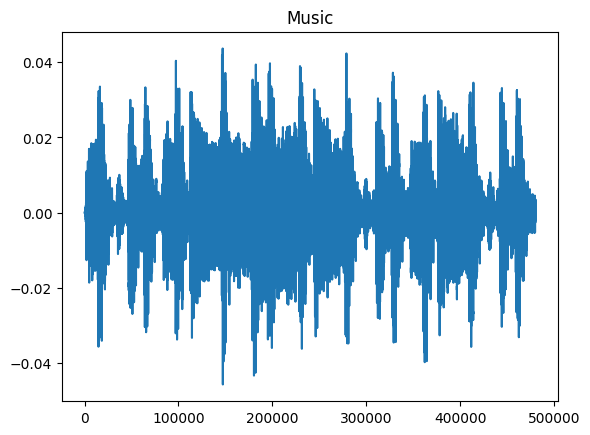

In [23]:
plt.plot(music_0)
plt.title('Music')
plt.show()

In [ ]:

'''
sample_rate = 48000

sd.play(music_0, sample_rate)

sd.wait()
'''


## added panel

In [24]:
print("Source position: ", D_1.speaker_xyz)
print("Listener position: ", D_1.xyzs[0])

Source position:  [3.5838 5.723  1.2294]
Listener position:  [2.4241125 0.581025  0.32     ]


In [20]:
L_1 = render.get_listener(source_xyz=D_1.speaker_xyz, listener_xyz = D_1.xyzs[0], surfaces=D_1.all_surfaces, 
                                                speed_of_sound=D_1.speed_of_sound,
                                                parallel_surface_pairs=D_1.parallel_surface_pairs,
                                                max_order=D_1.max_order, max_axial_order=D_1.max_axial_order )

Considered Paths:	100000
Total Considered Paths, after Axial:	100050
Valid Paths:	1146


In [22]:
R_1 = render.Renderer(n_surfaces=len(D_1.all_surfaces))

In [23]:
modified_energy_vector = torch.tensor([[[-0.5305, -0.4278, -0.2579, -0.3598, -1.6096, -0.7284, -1.8826,
          -1.6226, -1.5753, -1.9941],
         [ 0.5305,  0.4278,  0.2579,  0.3598,  1.6096,  0.7284,  1.8826,
           1.6226,  1.5753,  1.9941]],

        [[-2.4384,  0.8858, -0.2965, -1.5742, -0.2930, -1.9829, -1.7962,
          -1.9131, -0.0154,  0.2472],
         [ 2.4384, -0.8858,  0.2965,  1.5742,  0.2930,  1.9829,  1.7962,
           1.9131,  0.0154, -0.2472]],

        [[-0.9421, -0.6755, -3.6006, -0.7103, -0.8803, -1.3149, -2.2866,
          -2.6399, -2.8685, -2.1082],
         [ 0.9421,  0.6755,  3.6006,  0.7103,  0.8803,  1.3149,  2.2866,
           2.6399,  2.8685,  2.1082]],

        [[-4.0914, -2.7232, -0.8506, -2.3887, -3.6858, -1.3391, -2.6380,
          -1.8897, -2.1227, -3.5193],
         [ 4.0914,  2.7232,  0.8506,  2.3887,  3.6858,  1.3391,  2.6380,
           1.8897,  2.1227,  3.5193]],

        [[-1.1539, -0.4459, -0.3624, -0.7596, -0.7480, -1.5066, -0.9996,
          -2.1747, -0.6960, -2.0290],
         [ 1.1539,  0.4459,  0.3624,  0.7596,  0.7480,  1.5066,  0.9996,
           2.1747,  0.6960,  2.0290]],

        [[-1.7243, -1.1099, -0.0423, -1.1507, -1.2209, -0.4600, -2.0697,
          -2.2589, -2.4818, -1.5450],
         [ 1.7243,  1.1099,  0.0423,  1.1507,  1.2209,  0.4600,  2.0697,
           2.2589,  2.4818,  1.5450]],

        [[-7.8657, -7.9064, -4.2665, -2.9527, -0.6743, -0.7566,  1.5479,
          -1.3406, -2.4598, -2.1531],
         [ 7.8657,  7.9064,  4.2665,  2.9527,  0.6743,  0.7566, -1.5479,
           1.3406,  2.4598,  2.1531]],

        [[-4.5917, -5.2178, -4.6895, -3.5287, -3.0246,  0.2444, -1.6953,
          -1.4810, -1.9807, -1.9190],
         [ 4.5917,  5.2178,  4.6895,  3.5287,  3.0246, -0.2444,  1.6953,
           1.4810,  1.9807,  1.9190]],

        [[-6.7398, -2.8415, -3.7433, -0.8007, -2.0138, -1.9061, -2.0395,
          -2.8121, -3.1212, -2.7330],
         [ 6.7398,  2.8415,  3.7433,  0.8007,  2.0138,  1.9061,  2.0395,
          2.8121,  3.1212,  2.7330]],
           
        [[-6.7398, -2.8415, -3.7433, -0.8007, -2.0138, -1.9061, -2.0395,
          -2.8121, -3.1212, -2.7330],
         [ 6.7398,  2.8415,  3.7433,  0.8007,  2.0138,  1.9061,  2.0395,
          2.8121,  3.1212,  2.7330]]])

In [24]:
pt_file = torch.load('./models/classroomBase/weights.pt', map_location=device)
R_1.energy_vector = nn.Parameter(modified_energy_vector)
R_1.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R_1.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R_1.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R_1.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R_1.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

In [25]:
torch.cuda.empty_cache()

In [26]:
RIR_1 = R_1.render_RIR(L_1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 898.00 MiB. GPU 

In [ ]:
print(RIR_1.unsqueeze(0).shape)
print(D_1.music_dls[0:1,...].shape)

In [ ]:
music_1 = evaluate.render_music(RIR_1.unsqueeze(0), D_1.music_dls[0:1,...], device=device)[0][0]

In [ ]:
plt.plot(music_1)
plt.title('Music')
plt.show()

In [ ]:
'''
sample_rate = 48000

sd.play(music_1, sample_rate)

sd.wait()
'''